## Basic

In [2]:
# @title This analysis is done by Xianhui He, 29/07/2022
# @markdown contact me by xhhe.psy@gmail.com

In [1]:
# @title Data retrieval
import os, requests

fname = 'motor_imagery.npz'
url = "https://osf.io/ksqv8/download"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

In [3]:
# @title import `matplotlib` `sklearn` and set defaults
# install packages to visualize brains and electrode locations

!pip install mne --quiet

from matplotlib import rcParams
from matplotlib import pyplot as plt
import sklearn

from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_val_score
from sklearn import svm

import scipy
from scipy import stats
from scipy import signal

import random

rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] = 15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

     |████████████████████████████████| 7.5 MB 4.3 MB/s 


## SVM pipeline

In [4]:
# @title Data loading
import numpy as np

alldat = np.load(fname, allow_pickle=True)['dat']

print(alldat[1][0].keys())

dict_keys(['t_off', 'stim_id', 't_on', 'srate', 'V', 'scale_uv', 'locs', 'hemisphere', 'lobe', 'gyrus', 'Brodmann_Area'])


In [5]:
# @title select ROI channels
electrode_indexes = []
electrode_indexes.append([])
electrode_indexes.append([])

for subject_index, subject in enumerate(alldat):
  electrode_indexes[0].append([])
  electrode_indexes[1].append([])
  for gyrus_index, gyrus in enumerate(subject[0]['gyrus']):
    if gyrus == 'Precentral Gyrus':
      electrode_indexes[0][subject_index].append(gyrus_index)
    elif gyrus == 'Postcentral Gyrus':
      electrode_indexes[1][subject_index].append(gyrus_index)

# electrode_indexes: n_roi (0: Precentral gyrus; 1: Postcentral gyrus) * n_subs 

In [6]:
# @title function: get data & label for all ROI

def get_data_label_allroi(sub_ID, condi_ID, time_ID, band_limit):
  # Input:
    # sub_ID: 0-6
    # condi_ID: 0 refers to actual movement, 1 refers to imagery movement
    # time_ID: 0 refers to the first second, 1 refers to the sencond second
    # band_limit: band pass filter parameters, for example, input [8, 12] to obtain alpha power

  # output:
    # data: n_trials * n_features power matrix
    # label: n_trials label array

  from scipy import signal

  dat = alldat[sub_ID][condi_ID] 

  ele_used = np.concatenate((electrode_indexes[0][sub_ID],electrode_indexes[1][sub_ID]), axis=0)

  # filter the data
  # V is the voltage data
  V = dat['V'].astype('float32')
  V = V[:, ele_used]

  # low-pass filter below band_limit[1] Hz
  b, a = signal.butter(3, band_limit[1], btype='low', fs=1000)
  V = signal.filtfilt(b, a, V, 0)

  # high-pass filter above band_limit[0] Hz
  b, a = signal.butter(3, band_limit[0], btype='high', fs=1000)
  V = signal.filtfilt(b, a, V, 0)

  # calculate the power (hilbert)
  V_tmp = signal.hilbert(V) # 8-12
  V = np.abs(V_tmp) ** 2

  # data reconstruction into different epochs 
  nt, nchan = V.shape
  nstim = len(dat['t_on'])

  trange = np.arange(0, 2000)
  ts = dat['t_on'][:, np.newaxis]

  ts = ts + trange

  V_epochs = np.reshape(V[ts, :], (nstim, 2000, nchan))

  # average every 20 ms to obtain 50 time points for each channel
  data = np.empty((nstim,0),int)

  for it in range(50):
    V_epochs_tmp = V_epochs[:, [it * 20 + time_ID * 1000, (it + 1) * 20 - 1 + time_ID * 1000], :]
    data_tmp = np.mean(V_epochs_tmp, 1)
    data = np.hstack((data, data_tmp))

  label = dat['stim_id']

  return data, label

In [11]:
# @title function: SVM classifier training, leave-one-trial-out cross-validation and generalization

def train_svm(sub_ID, condi_ID, time_ID, band_limit):

  # Input:
    # sub_ID: 0-6
    # condi_ID: 0 refers to actual movement, 1 refers to imagery movement
    # time_ID: 0 refers to the first second, 1 refers to the sencond second
    # band_limit: band pass filter parameters, for example, input [8, 12] to obtain alpha power

  # output:
    # test_acc: cross-validation performance of the SVM
    # training_acc: training performance of the SVM
    # gen_acc: generalization performance of the SVM

  data, label = get_data_label_allroi(sub_ID, condi_ID, time_ID, band_limit)

  # create arrays for each trial
  test_accuracies = np.ones(60)
  train_accuracies = np.ones(60)

  # split the data (leave-one-trial-out) 
  loo = LeaveOneOut()
  loo.get_n_splits(data)

  # train and test the classifier
  for train_index, test_index in loo.split(data):
    classifier = svm.SVC(C = 1, kernel = 'linear')
    classifier.fit(data[train_index], label[train_index])

    train_accuracies[test_index] = classifier.score(data[train_index], label[train_index])
    test_accuracies[test_index] = classifier.score(data[test_index], label[test_index])

  # generalization
  gen_data, gen_label = get_data_label_allroi(sub_ID, 1-condi_ID, time_ID, band_limit)
  
  classifier = svm.SVC(C = 1, kernel = 'linear')
  classifier.fit(data, label)
  gen_acc = classifier.score(gen_data, gen_label)

  return test_accuracies.mean(), train_accuracies.mean(), gen_acc


In [12]:
# @title calculation and showing the group average results

# for example sub
# sub_ID : 0-6
# condi_ID : 0 actual; 1 imagery
# time_ID : 0 0-999; 1 1000-1999

# basic setting
band_limit = [13, 30]
band_name = 'beta band';

test_acc = np.ones(shape=(2,7,2))
train_acc = np.ones(shape=(2,7,2))
gen_acc = np.ones(shape=(2,7,2))

condi_name = ['actual', 'imagery']
gen_name = ['actual→imagery', 'imagery→actual']

for itime in range(2):
  for icondi in range(2):
    for isub in range(7):
     test_acc[itime][isub][icondi], train_acc[itime][isub][icondi], gen_acc[itime][isub][icondi]= train_svm(isub, icondi, itime, band_limit)

    print("time: ", itime, "-", itime + 1, "s")
    print("training score: ", condi_name[icondi], np.mean(train_acc[itime, :, icondi], 0))
    print("cross-validation score: ", condi_name[icondi], np.mean(acc[itime, :, icondi], 0))
    print("generalization score: ", gen_name[icondi], np.mean(gen_acc[itime, :, icondi], 0))


time:  0 - 1 s
training score:  actual 0.9660613397901533
cross-validation score:  actual 1.0
generalization score:  actual→imagery 0.5285714285714286
time:  0 - 1 s
training score:  imagery 0.9644874899112187
cross-validation score:  imagery 1.0
generalization score:  imagery→actual 0.5428571428571429
time:  1 - 2 s
training score:  actual 0.9618240516545601
cross-validation score:  actual 1.0
generalization score:  actual→imagery 0.5666666666666667
time:  1 - 2 s
training score:  imagery 0.9457223567393059
cross-validation score:  imagery 1.0
generalization score:  imagery→actual 0.5976190476190475


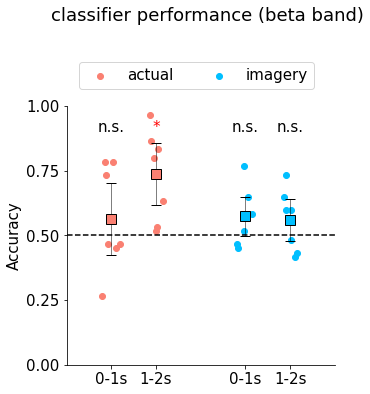

In [14]:
#@title Run to plot out test accuracy scores.
#@markdown 
condi_name = ['actual', 'imagery']
time_name = ['0-2s']
color_name = ['salmon', 'lightsalmon', 'deepskyblue', 'lightskyblue']

f, ax = plt.subplots(nrows=1, ncols=1, figsize = (5,5))
    
for itime in range(2):
  for icondi in range(2):
    y = np.mean(test_acc[itime, :, icondi], 0)
    yerr = np.std(test_acc[itime, :, icondi], 0) * 1.96 / np.sqrt(7)

    scatter_x = np.ones((7))
    for isub in range(7):
      scatter_x[isub] = itime + icondi * 3 + 1 + random.randint(-20, 20)/100

    ax.errorbar(itime + icondi * 3 + 1, y, yerr = yerr, ecolor = 'k', elinewidth = 0.5,
                marker = 's', mfc = color_name[icondi * 2], mec = 'k', mew = 1, ms = 10,
                capsize = 5, capthick = 3, 
                label = condi_name[icondi])
    ax.scatter(scatter_x, test_acc[itime, :, icondi], c = color_name[icondi * 2])

    t, p = stats.ttest_1samp(test_acc[itime, :, icondi], 0.5)

    if p >0.1:
      plt.text(itime + icondi * 3 + 1, 0.9, 'n.s.', horizontalalignment='center')
    elif p < 0.1 and p > 0.05:
      plt.text(itime + icondi * 3 + 1, 0.9, '+', c='r', horizontalalignment='center')
    elif p < 0.05 and p > 0.01:
      plt.text(itime + icondi * 3 + 1, 0.9, '*', c='r', horizontalalignment='center')
    elif p < 0.01 and p > 0.001:
      plt.text(itime + icondi * 3 + 1, 0.9, '**', c='r', horizontalalignment='center')
    elif p < 0.001:
      plt.text(itime + icondi * 3 + 1, 0.9, '***', c='r', horizontalalignment='center')
    
ax.set(
  yticks=[0, 0.25, 0.5, 0.75, 1],
  xlim=(0, 6),
  ylim=(0, 1),
  ylabel='Accuracy'
)
plt.xticks([1, 2, 4, 5], ['0-1s', '1-2s', '0-1s', '1-2s'])
   
plt.hlines(0.5, 0, 6, colors='k', linestyles='dashed')

plt.legend(condi_name, loc=1, bbox_to_anchor=(0.95, 1.2), ncol =2)
title = "classifier performance (%s)" % band_name
plt.suptitle(title, x=0.6, y=1.1)
plt.show()

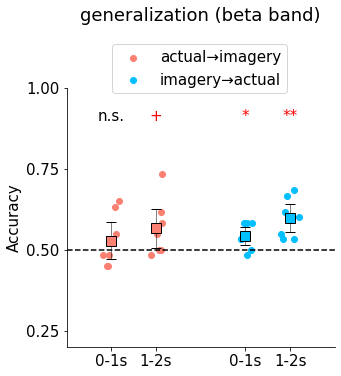

In [ ]:
#@title Run to plot out generalization accuracy scores.
#@markdown 
condi_name = ['actual→imagery', 'imagery→actual']
time_name = ['0-2s']
color_name = ['salmon', 'lightsalmon', 'deepskyblue', 'lightskyblue']

f, ax = plt.subplots(nrows=1, ncols=1, figsize = (5,5))
    
for itime in range(2):
  for icondi in range(2):
    y = np.mean(gen_acc[itime, :, icondi], 0)
    yerr = np.std(gen_acc[itime, :, icondi], 0) * 1.96 / np.sqrt(7)

    scatter_x = np.ones((7))
    for isub in range(7):
      scatter_x[isub] = itime + icondi * 3 + 1 + random.randint(-20, 20)/100

    ax.errorbar(itime + icondi * 3 + 1, y, yerr = yerr, ecolor = 'k', elinewidth = 0.5,
                marker = 's', mfc = color_name[icondi * 2], mec = 'k', mew = 1, ms = 10,
                capsize = 5, capthick = 3, 
                label = condi_name[icondi])
    ax.scatter(scatter_x, gen_acc[itime, :, icondi], c = color_name[icondi * 2])
    t, p = stats.ttest_1samp(gen_acc[itime, :, icondi], 0.5)

    if p >0.1:
      plt.text(itime + icondi * 3 + 1, 0.9, 'n.s.', horizontalalignment='center')
    elif p < 0.1 and p > 0.05:
      plt.text(itime + icondi * 3 + 1, 0.9, '+', c='r', horizontalalignment='center')
    elif p < 0.05 and p > 0.01:
      plt.text(itime + icondi * 3 + 1, 0.9, '*', c='r', horizontalalignment='center')
    elif p < 0.01 and p > 0.001:
      plt.text(itime + icondi * 3 + 1, 0.9, '**', c='r', horizontalalignment='center')
    elif p < 0.001:
      plt.text(itime + icondi * 3 + 1, 0.9, '***', c='r', horizontalalignment='center')
    
ax.set(
  yticks=[0.25, 0.5, 0.75, 1],
  xlim=(0, 6),
  ylim=(0.2, 1),
  ylabel='Accuracy'
)
plt.xticks([1, 2, 4, 5], ['0-1s', '1-2s', '0-1s', '1-2s'])
   
plt.hlines(0.5, 0, 6, colors='k', linestyles='dashed')

plt.legend(condi_name, loc=1, bbox_to_anchor=(0.85, 1.2))
title = "generalization (%s)" % band_name
plt.suptitle(title, x=0.58, y=1.05)
plt.show()